# Animal Verification MVP

This notebook demonstrates a pipeline that:
1. Extracts animal mentions from text using NER (with negation handling)
2. Classifies animals in images
3. Verifies whether the text claim matches the image

The goal is to detect animal claims in user text and check their correctness against the image.

In [12]:
# support imports
import sys
from pathlib import Path

project_root = Path().resolve().parent
sys.path.append(str(project_root))

## 1️⃣ Generate data for NER model

In [13]:
!python ../utils/generate_ner_data.py

✅ Generated 440 train and 110 val samples in /Users/olhaopanasenko/Documents/GitHub/winstars/internship_test/task_2/utils/../data/ner/


## 2️⃣ Data Exploration (NER)

In [ ]:
import json

# Load data
with open("../data/ner/train.json", encoding="utf-8") as f:
    train_data = json.load(f)
with open("../data/ner/val.json", encoding="utf-8") as f:
    val_data = json.load(f)

# Display sample
train_data[0]

{'tokens': ['A', 'cat', 'is', 'running', 'fast', '.'],
 'ner_tags': ['O', 'B-ANIMAL', 'O', 'O', 'O', 'O']}

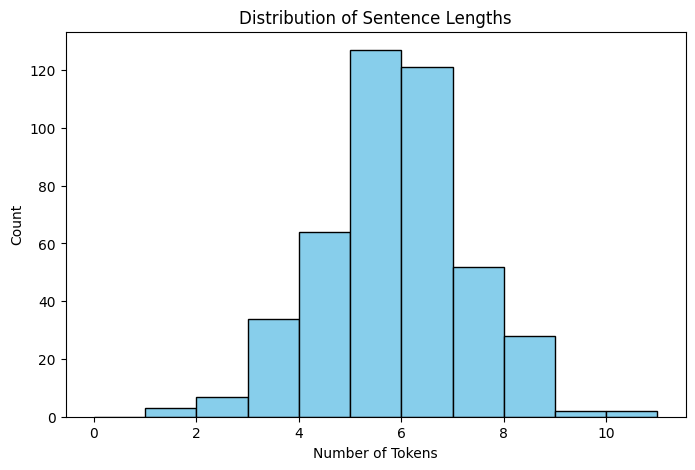

In [15]:
import matplotlib.pyplot as plt
from collections import Counter

# Sentence Length Histogram
sentence_lengths = [len(sample["tokens"]) for sample in train_data]

plt.figure(figsize=(8,5))
plt.hist(sentence_lengths, bins=range(0, max(sentence_lengths)+2, 1), color='skyblue', edgecolor='black')
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Number of Tokens")
plt.ylabel("Count")
plt.show()

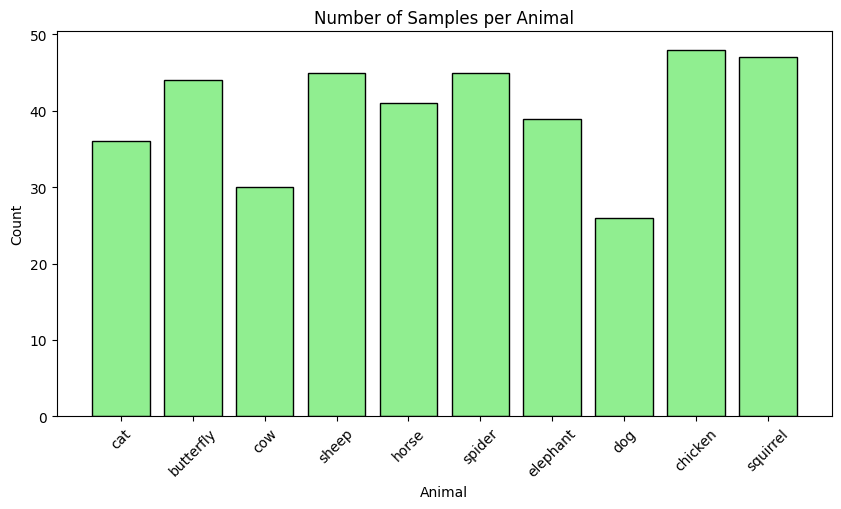

In [16]:
# Bar Chart: Samples per Animal
animal_counts = Counter()
for sample in train_data:
    for token, tag in zip(sample["tokens"], sample["ner_tags"]):
        if tag == "B-ANIMAL":
            animal_counts[(token)] += 1

plt.figure(figsize=(10,5))
plt.bar(animal_counts.keys(), animal_counts.values(), color='lightgreen', edgecolor='black')
plt.title("Number of Samples per Animal")
plt.xlabel("Animal")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

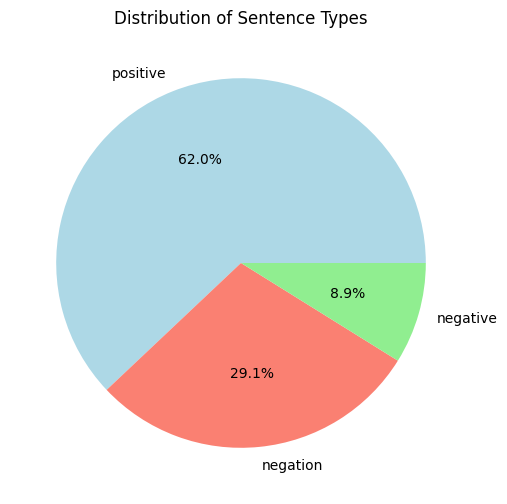

In [17]:
# Pie Chart: Sentence Types
types_counts = Counter()
for sample in train_data:
    if any(tag=="B-ANIMAL" for tag in sample["ner_tags"]):
        if any(word.lower() in ["not", "no", "never", "n't", "without", "none", "nothing"] for word in sample["tokens"]):
            types_counts["negation"] += 1
        else:
            types_counts["positive"] += 1
    else:
        types_counts["negative"] += 1

plt.figure(figsize=(6,6))
plt.pie(types_counts.values(), labels=types_counts.keys(), autopct='%1.1f%%', colors=['lightblue','salmon','lightgreen'])
plt.title("Distribution of Sentence Types")
plt.show()

## 3️⃣ Token & Label Visualization

In [18]:
# Show first 5 token-label pairs
for ex in train_data[:5]:
    print(list(zip(ex["tokens"], ex["ner_tags"])))

[('A', 'O'), ('cat', 'B-ANIMAL'), ('is', 'O'), ('running', 'O'), ('fast', 'O'), ('.', 'O')]
[('Without', 'O'), ('a', 'O'), ('butterfly', 'B-ANIMAL'), ('.', 'O')]
[('There', 'O'), ('is', 'O'), ('no', 'O'), ('butterfly', 'B-ANIMAL'), ('here', 'O')]
[('Without', 'O'), ('a', 'O'), ('butterfly', 'B-ANIMAL'), ('.', 'O')]
[('Looks', 'O'), ('like', 'O'), ('an', 'O'), ('empty', 'O'), ('field', 'O'), ('.', 'O')]


## 4️⃣ NER Model Training Overview

In [19]:
!python ../ner/train.py

Map: 100%|██████████████████████████| 110/110 [00:00<00:00, 16292.01 examples/s]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/olhaopanasenko/Documents/GitHub/winstars/internship_test/task_2/notebooks/../ner/train.py:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  0%|                                                   | 0/140 [00:00<?, ?it/s]/Users/olhaopanasenko/Documents/GitHub/winstars/internship_test/task_2/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|  

## 5️⃣ Image Classification Overview

In [25]:
!python ../utils/download_vision_data.py

Cached dataset files at: /Users/olhaopanasenko/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2
Renamed gallina to chicken
Renamed ragno to spider
Renamed gatto to cat
Renamed farfalla to butterfly
Renamed mucca to cow
Renamed cavallo to horse
Renamed cane to dog
Renamed pecora to sheep
Renamed scoiattolo to squirrel
Renamed elefante to elephant
Copied to: /Users/olhaopanasenko/Documents/GitHub/winstars/internship_test/task_2/utils/../data/animals


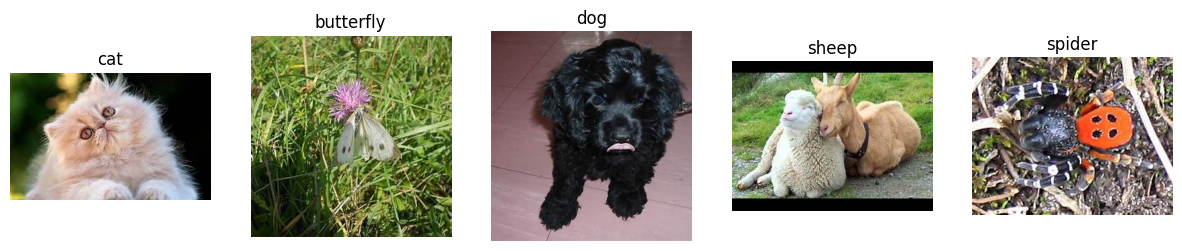

In [26]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import os

IMAGE_DIR = "../data/animals"
classes = [d for d in os.listdir(IMAGE_DIR) if not d.startswith(".")][:5]  # show first 5 classes
fig, axs = plt.subplots(1,5, figsize=(15,3))

for i, cls in enumerate(classes):
    cls_path = os.path.join(IMAGE_DIR, cls)
    img_file = os.listdir(cls_path)[0]
    img = mpimg.imread(os.path.join(cls_path, img_file))
    axs[i].imshow(img)
    axs[i].set_title(cls)
    axs[i].axis('off')
plt.show()

## 6️⃣ Pipeline Demonstration

In [22]:
from pipeline.pipeline import verify_text_image_claim

# Positive claim
verify_text_image_claim("There is a horse in the picture.", "../test_images/horse/0001.jpeg")

# Negated claim
verify_text_image_claim("not a dog", "../test_images/cow/0001.jpeg")
verify_text_image_claim("I don't think it's a sheep", "../test_images/dog/0001.jpeg")

# Another example
verify_text_image_claim("Look, a cat over there!", "../test_images/cat/0001.jpeg")


[{'word': 'horse', 'index': 3}]
Text: 'There is a horse in the picture.'
Detected animal: horse | Negated: False
Image prediction: cat
Pipeline result: False

Text: 'not a dog'
No animal detected in text.
Pipeline result: False

[{'word': 'sheep', 'index': 5}]
Text: 'I don't think it's a sheep'
Detected animal: sheep | Negated: True
Image prediction: butterfly
Pipeline result: True

[{'word': 'cat', 'index': 2}]
Text: 'Look, a cat over there!'
Detected animal: cat | Negated: False
Image prediction: elephant
Pipeline result: False


False